Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [2]:
# Read in the data sets
df = pd.read_csv("data/nat2019us.csv")

C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.columns

Index(['dob_yy', 'dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'f_facility',
       'bfacil3', 'mage_impflg', 'mage_repflg', 'mager',
       ...
       'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom', 'f_ca_hypos',
       'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed'],
      dtype='object', length=226)

In [4]:
df.head()

,dob_yy,dob_mm,dob_tt,dob_wk,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,...,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen,itran,ilive,bfed,f_bfed
0,2019,1,1135,3,1,1,1,NaN,NaN,29,...,1,1,1,1,1,1,N,Y,Y,1
1,2019,1,1305,3,1,1,1,NaN,NaN,40,...,1,1,1,1,1,1,N,Y,Y,1
2,2019,1,800,3,1,1,1,NaN,NaN,30,...,1,1,1,1,1,1,N,Y,Y,1
3,2019,1,130,4,1,1,1,NaN,NaN,25,...,1,1,1,1,1,1,N,Y,Y,1
4,2019,1,1426,4,1,1,1,NaN,NaN,38,...,1,1,1,1,1,1,N,Y,Y,1


Columns are removed for the following reasons:
- They are storing metadata about the collection of the data minor processing tasks performed
- They are pre-binned for a specific purpose outside the scope of this analysis
- They are slight variations of existing columns which are more applicable to this analysis
- They represent events that happen after birth has already occurred

In [6]:
remove = ['dob_yy', 'f_facility', 'bfacil3', 'mage_impflg', 'mage_repflg', 'mager14', 'mager9', 'mrace31', 'mrace6', 'mrace15',
           'mraceimp', 'mhispx', 'f_mhisp', 'mracehisp', 'mar_p', 'mar_imp', 'f_mar_p', 'f_meduc', 'fagerpt_flg', 'fagerec11',
           'frace31', 'frace15', 'fhispx', 'f_fhisp', 'lbo_rec', 'tbo_rec', 'illb_r', 'illb_r11', 'ilop_r',
           'ilop_r11', 'ilp_r11', 'f_mpcb', 'precare5', 'previs_rec', 'f_tpcv', 'f_wic', 'cig0_r', 'cig1_r', 'cig2_r',
           'cig3_r', 'f_cigs_0', 'f_cigs_1', 'f_cigs_2', 'f_cigs_3', 'cig_rec', 'f_tobaco', 'f_m_ht', 'bmi_r', 'pwgt_r',
           'f_pwgt', 'f_dwgt', 'wtgain_rec', 'f_wtgain', 'f_rf_pdiab', 'f_rf_gdiab', 'f_rf_phyper', 'f_rf_ghyper', 
           'f_rf_eclamp', 'f_rf_ppb', 'f_rf_inf_drg', 'f_rf_inf_art', 'rf_cesar', 'f_rf_cesar', 'f_rf_ncesar',
           'no_risks', 'f_ip_gonor', 'f_ip_syph', 'f_ip_chlam', 'f_ip_hepatb', 'f_ip_hepatc', 'no_infec', 'ob_ecvs', 'ob_ecvf',
           'f_ob_succ', 'f_ob_fail', 'ld_indl', 'ld_augm', 'ld_anes', 'f_ld_indl', 'f_ld_augm', 'f_ld_ster', 'f_ld_antb',
           'f_ld_chor', 'f_ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial', 'f_me_pres', 'f_me_rout', 'f_me_trial',
           'rdmeth_rec', 'dmeth_rec', 'f_dmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'f_mm_mtr',
           'f_mm_rupt', 'f_mm_uhyst', 'f_mm_aicu', 'no_mmorb', 'mtran', 'pay', 'f_pay', 'f_pay_rec', 'apgar5r',
           'f_apgar5', 'apgar10', 'apgar10r', 'imp_plur', 'setorder_r', 'imp_sex', 'dlmp_mm', 'dlmp_yy', 'compgst_imp',
           'obgest_flg', 'gestrec10', 'gestrec3', 'lmpused', 'oegest_comb', 'oegest_r10', 'dbwt', 'bwtr12', 'bwtr4',
           'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'f_ab_vent', 'f_ab_vent6',
           'f_ab_surfac', 'f_ab_antibio', 'f_ab_seiz', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 
           'ca_gast', 'f_ca_anen', 'f_ca_menin', 'f_ca_heart', 'f_ca_hernia', 'f_ca_ompha', 'f_ca_gastro', 'ca_limb',
           'ca_cleft', 'ca_clpal', 'ca_disor', 'ca_hypo', 'f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 
           'f_ca_chrom', 'f_ca_hypos', 'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed', 'f_mm_', 'f_ab_nicu', 'fracehisp',
           'oegest_r3', 'dob_mm', 'dob_tt', 'dob_wk', 'restatus', 'frace6', 'fhisp_r', 'feduc', 'ilp_r']

In [7]:
df.drop(remove, axis=1, inplace=True)
df.columns

Index(['bfacil', 'mager', 'mbstate_rec', 'mbrace', 'mhisp_r', 'dmar', 'meduc',
       'fagecomb', 'priorlive', 'priordead', 'priorterm', 'precare', 'previs',
       'wic', 'cig_0', 'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'bmi', 'dwgt_r',
       'wtgain', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype',
       'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'rf_cesarn', 'ip_gon',
       'ip_syph', 'ip_chlam', 'ip_hepatb', 'ip_hepatc', 'ld_ster', 'ld_antb',
       'ld_chor', 'attend', 'pay_rec', 'apgar5', 'dplural', 'sex', 'combgest',
       'ca_downs'],
      dtype='object')

In [8]:
rename = ['birth_place', 'mother_age', 'mother_native',
          'mother_race', 'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
          'living_children', 'deceased_children', 'terminations', 
          'months_prenatal_care', 'prenatal_visits', 'food_assistance', 'prepregnancy_daily_cig',
          'first_tri_daily_cig', 'second_tri_daily_cig', 'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
          'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension', 'gestational_hypertension', 'eclampsia',
          'previous_premature_birth', 'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
          'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
          'chorioamnionitis', 'attendant', 'payment_method', 'apgar_score', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
          'down_syndrome']

In [9]:
df.columns = rename

## Target Engineering

In [10]:
df['apgar_score'].value_counts()

9     3094327
8      417480
7       77895
10      75873
6       30450
5       16107
99      14673
4        9028
1        7415
3        6507
2        5781
0        2046
Name: apgar_score, dtype: int64

In [11]:
df['apgar_score'].replace(to_replace=list(range(0, 7)), value=0, inplace=True)

In [12]:
df['apgar_score'].replace(to_replace=list(range(7, 11)), value=1, inplace=True)

In [13]:
df.drop(df.loc[df['apgar_score']==99].index, inplace=True)

In [14]:
df['apgar_score'].value_counts()

1    3665575
0      77334
Name: apgar_score, dtype: int64

## Feature Processing

In [15]:
df.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'attendant', 'payment_method', 'apgar_score',
       'plural_pregnancy', 'infant_sex', 'weeks_gestation', 'down_syndrome'],
      dtype='object')

In [16]:
df['birth_place'].value_counts()

1    3686903
3      27698
2      20723
5       2559
4       2338
7       2096
6        530
9         62
Name: birth_place, dtype: int64

In [17]:
df['birth_place'].replace(to_replace=list(range(2, 8)), value="other", inplace=True)
df['birth_place'].replace(to_replace=1, value="hospital", inplace=True)
df['birth_place'].replace(to_replace=9, value=np.nan, inplace=True)

In [18]:
df['mother_native'].value_counts()

1    2885074
2     850158
3       7677
Name: mother_native, dtype: int64

In [19]:
df['mother_native'].replace(to_replace=2, value=0, inplace=True)
df['mother_native'].replace(to_replace=3, value=np.nan, inplace=True)

In [20]:
df['mother_race'].value_counts()

1    2788731
2     632382
4     280217
3      41579
Name: mother_race, dtype: int64

In [21]:
df['mother_race'].replace({1: 'white', 2: 'black', 3: 'native_american', 4: 'asian/pi'}, inplace=True)

In [22]:
# Place of birth
counts = (df[['mother_race', 'apgar_score']]
              .groupby(['mother_race', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

In [23]:
counts['percent_low_apgar'] = (counts[0]/counts[1])*100

In [24]:
counts['percent_low_apgar']

mother_race
asian/pi           1.605575
black              3.212339
native_american    2.391154
white              1.909498
Name: percent_low_apgar, dtype: float64

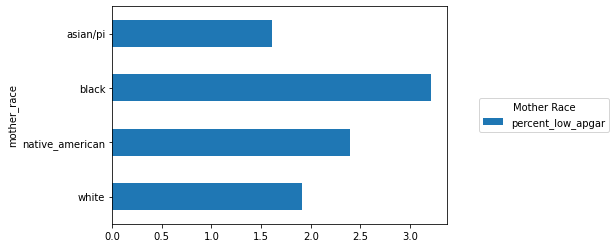

In [25]:
ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Mother Race'
)

In [26]:
df['mother_hispanic'].value_counts()

0    2816958
1     502208
4     164721
5     129573
2      70711
9      35104
3      23634
Name: mother_hispanic, dtype: int64

In [27]:
df['mother_hispanic'].replace(to_replace=list(range(1, 6)), value=1, inplace=True)
df['mother_hispanic'].replace(to_replace=9, value=np.nan, inplace=True)

In [28]:
df['marital_status'].value_counts()

1.0    1968696
2.0    1330007
Name: marital_status, dtype: int64

In [29]:
df['marital_status'].replace({1: 'married', 2: 'unmarried'}, inplace=True)

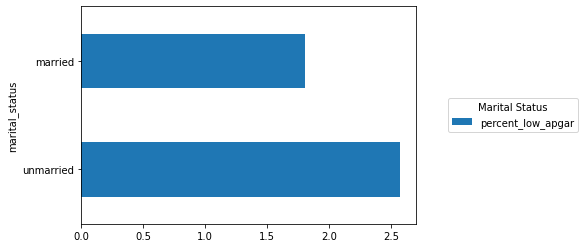

In [30]:
counts = (df[['marital_status', 'apgar_score']]
              .groupby(['marital_status', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Marital Status'
)

In [31]:
df['mother_education'].value_counts()

3    963465
6    772775
4    727697
7    360017
2    336834
5    309359
1    115068
8    104489
9     53205
Name: mother_education, dtype: int64

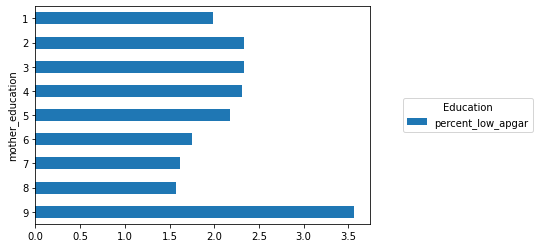

In [32]:
counts = (df[['mother_education', 'apgar_score']]
              .groupby(['mother_education', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Education'
)

In [33]:
df['mother_education'].replace(to_replace=list(range(1, 6)), value="hs_or_lower", inplace=True)
df['mother_education'].replace(to_replace=list(range(6, 9)), value="college_or_higher", inplace=True)
df['mother_education'].replace(to_replace=9, value=np.nan, inplace=True)

In [34]:
df['father_age'].value_counts()

99    430117
31    202868
32    200782
30    197125
33    197000
       ...  
93         1
86         1
84         1
98         1
87         1
Name: father_age, Length: 80, dtype: int64

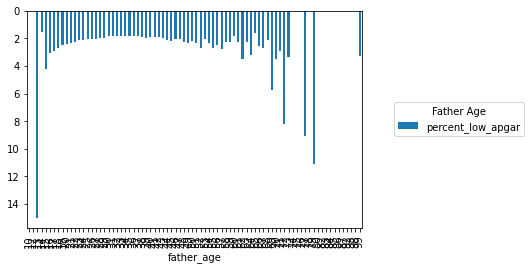

In [35]:
counts = (df[['father_age', 'apgar_score']]
              .groupby(['father_age', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Father Age'
)

In [36]:
df['father_age'].replace(to_replace=99, value=np.nan, inplace=True)

In [37]:
df['living_children'].value_counts()

0     1437973
1     1193311
2      637706
3      274877
4      107747
5       45341
6       20164
7        9821
99       5041
8        4979
9        2845
10       1637
11        811
12        413
13        129
14         66
15         27
16         13
17          4
20          2
18          2
Name: living_children, dtype: int64

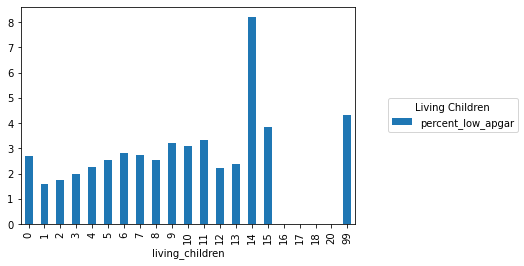

In [38]:
counts = (df[['living_children', 'apgar_score']]
              .groupby(['living_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Living Children'
)

In [39]:
df['living_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [40]:
df['deceased_children'].value_counts()

0     3691909
1       36560
99       7396
2        4564
3        1112
4         399
5         231
9         158
6         152
7         124
8         119
10         87
12         49
11         48
17          1
Name: deceased_children, dtype: int64

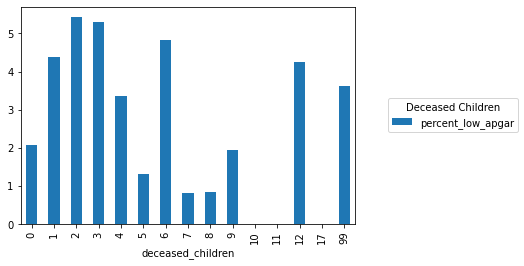

In [41]:
counts = (df[['deceased_children', 'apgar_score']]
              .groupby(['deceased_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Deceased Children'
)

In [42]:
df['deceased_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [43]:
df['terminations'].value_counts()

0     2710073
1      667012
2      226272
3       78874
4       28715
5       11658
99       8340
6        5211
7        2680
8        1476
9         882
10        802
11        348
12        260
13         97
14         63
15         54
16         32
17         14
18         14
23          8
20          7
19          6
25          3
30          2
22          2
21          2
24          1
27          1
Name: terminations, dtype: int64

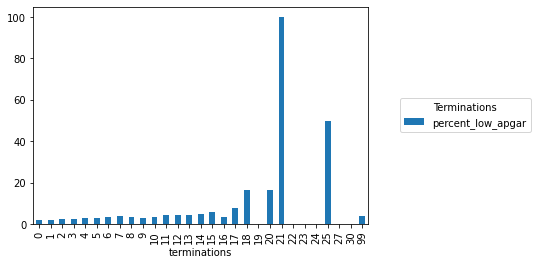

In [44]:
counts = (df[['terminations', 'apgar_score']]
              .groupby(['terminations', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Terminations'
)

In [45]:
df['terminations'].replace(to_replace=99, value=np.nan, inplace=True)

In [46]:
df['months_prenatal_care'].value_counts()

2     1475542
3     1152091
4      323210
1      212144
5      163052
6      100782
99      83396
7       79773
0       66419
8       61274
9       24838
10        388
Name: months_prenatal_care, dtype: int64

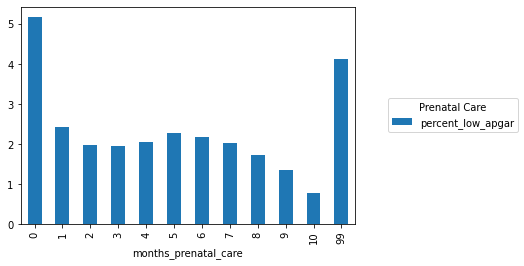

In [47]:
counts = (df[['months_prenatal_care', 'apgar_score']]
              .groupby(['months_prenatal_care', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Care'
)

In [48]:
df['months_prenatal_care'].replace(to_replace=99, value=np.nan, inplace=True)

In [49]:
df['prenatal_visits'].value_counts()

12    576719
10    481612
11    377871
13    358086
14    299447
       ...  
94         1
86         1
73         1
74         1
83         1
Name: prenatal_visits, Length: 92, dtype: int64

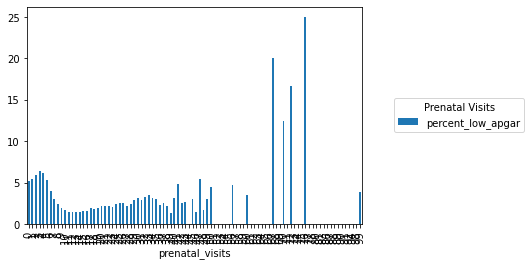

In [50]:
counts = (df[['prenatal_visits', 'apgar_score']]
              .groupby(['prenatal_visits', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Visits'
)

In [51]:
df['prenatal_visits'].replace(to_replace=99, value=np.nan, inplace=True)

In [52]:
df['food_assistance'].value_counts()

N    2447990
Y    1252530
U      42389
Name: food_assistance, dtype: int64

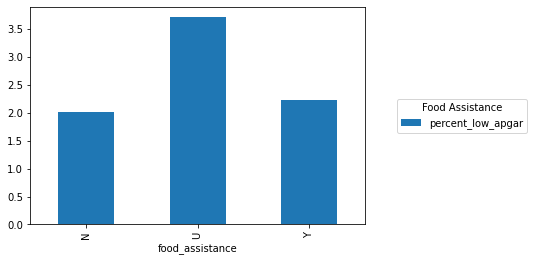

In [53]:
counts = (df[['food_assistance', 'apgar_score']]
              .groupby(['food_assistance', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

In [54]:
df['prenatal_visits'].replace(to_replace='U', value=np.nan, inplace=True)

In [55]:
df['prepregnancy_daily_cig'].value_counts()

0     3438762
20      84271
10      76956
5       30445
99      18529
       ...   
54          1
71          1
52          1
76          1
56          1
Name: prepregnancy_daily_cig, Length: 74, dtype: int64

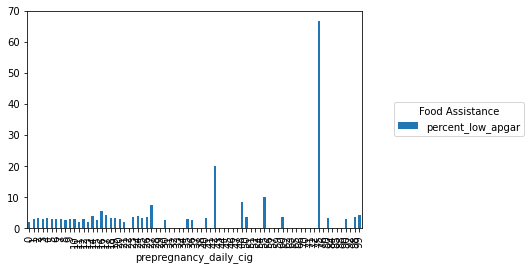

In [56]:
counts = (df[['prepregnancy_daily_cig', 'apgar_score']]
              .groupby(['prepregnancy_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

In [66]:
df['first_tri_daily_cig'].value_counts()

0     3508892
10      68102
20      44271
5       29963
99      18453
       ...   
65          1
66          1
68          1
75          1
47          1
Name: first_tri_daily_cig, Length: 69, dtype: int64

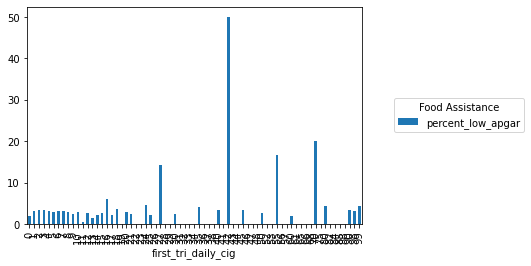

In [67]:
counts = (df[['first_tri_daily_cig', 'apgar_score']]
              .groupby(['first_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig1'
)

In [89]:
df['first_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [69]:
df['second_tri_daily_cig'].value_counts()

0     3539918
10      61391
5       30895
20      27295
99      18381
       ...   
95          1
57          1
72          1
82          1
85          1
Name: second_tri_daily_cig, Length: 61, dtype: int64

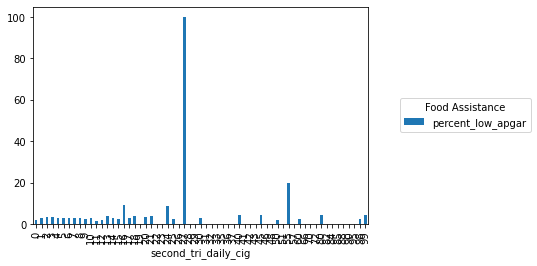

In [70]:
counts = (df[['second_tri_daily_cig', 'apgar_score']]
              .groupby(['second_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig2'
)

In [90]:
df['second_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [72]:
df['third_tri_daily_cig'].value_counts()

0     3531455
10      52799
99      36979
5       31074
20      23447
3       14361
2       12642
1        9890
4        9882
6        6048
7        3838
8        3022
15       2767
40        978
12        833
30        681
9         652
98        364
60        242
11        176
13        104
25        100
80         90
14         77
18         56
50         51
16         51
24         41
17         30
35         23
21         23
19         20
45         19
90         17
22         12
23         10
55          8
88          6
28          6
36          4
26          3
32          3
27          2
31          2
33          2
34          2
42          2
48          2
84          2
29          2
37          1
38          1
92          1
41          1
46          1
62          1
63          1
66          1
70          1
Name: third_tri_daily_cig, dtype: int64

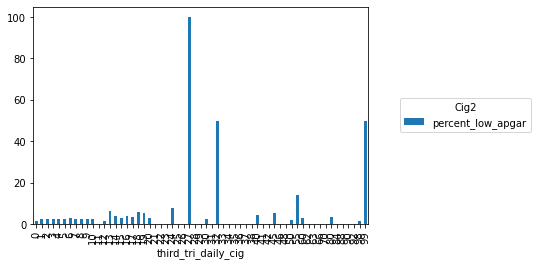

In [73]:
counts = (df[['third_tri_daily_cig', 'apgar_score']]
              .groupby(['third_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [91]:
df['third_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [75]:
df['height'].value_counts()

64    548128
63    488093
62    476552
65    445686
66    405942
67    322452
61    270261
60    208102
68    178443
69    120336
59     87930
70     58927
71     31241
58     23487
57     19676
99     18795
72     14246
56      6963
73      4837
55      3029
74      2338
54      1357
53      1298
75       825
78       741
49       565
48       533
52       470
76       445
77       432
51       355
50       300
30        27
47        15
39        15
40        11
45        10
41         8
46         7
36         7
44         6
38         5
43         4
42         3
37         2
35         2
34         1
31         1
Name: height, dtype: int64

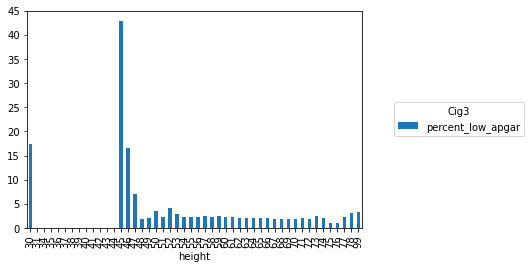

In [76]:
counts = (df[['height', 'apgar_score']]
              .groupby(['height', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [92]:
df['height'].replace(to_replace=99, value=np.nan, inplace=True)

In [78]:
df['bmi'].value_counts()

99.9    84201
26.6    68007
28.3    59928
23.0    46399
22.3    44956
        ...  
67.9        1
66.7        1
69.0        1
69.6        1
67.2        1
Name: bmi, Length: 567, dtype: int64

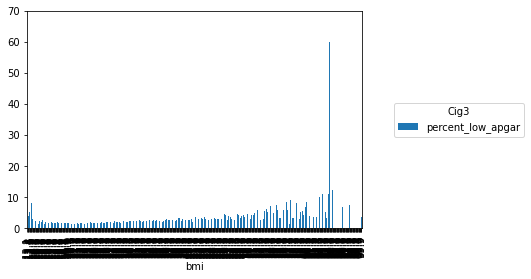

In [79]:
counts = (df[['bmi', 'apgar_score']]
              .groupby(['bmi', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [93]:
df['bmi'].replace(to_replace=99, value=np.nan, inplace=True)

In [81]:
df['delivery_weight'].value_counts()

160    71167
180    70913
170    67510
165    58274
150    57122
       ...  
393       87
398       87
394       82
387       79
397       77
Name: delivery_weight, Length: 302, dtype: int64

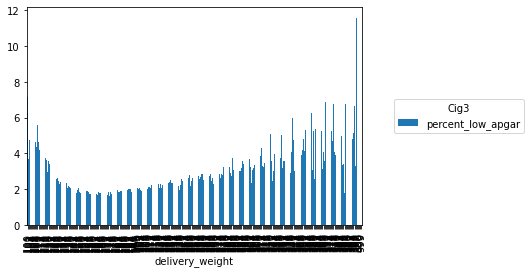

In [82]:
counts = (df[['delivery_weight', 'apgar_score']]
              .groupby(['delivery_weight', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [94]:
df['delivery_weight'].replace(to_replace=999, value=np.nan, inplace=True)

In [84]:
df['weight_gain'].value_counts()

30    164774
20    136218
25    126570
35    114184
99    108997
       ...  
92       432
93       418
94       381
96       331
97       299
Name: weight_gain, Length: 100, dtype: int64

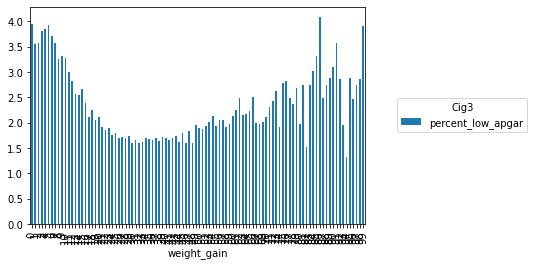

In [85]:
counts = (df[['weight_gain', 'apgar_score']]
              .groupby(['weight_gain', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [95]:
df['weight_gain'].replace(to_replace=99, value=np.nan, inplace=True)

In [87]:
df['diabetes'].value_counts()

N    3704010
Y      36516
U       2383
Name: diabetes, dtype: int64

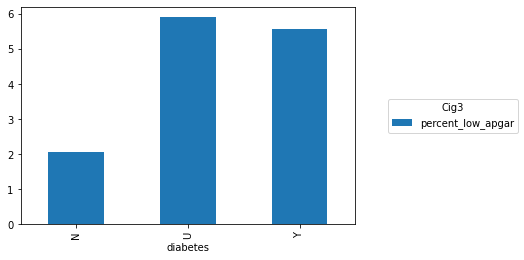

In [88]:
counts = (df[['diabetes', 'apgar_score']]
              .groupby(['diabetes', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [96]:
df['diabetes'].replace(to_replace='U', value=np.nan, inplace=True)

In [97]:
df['gestational_diabetes'].value_counts()

N    3481937
Y     258589
U       2383
Name: gestational_diabetes, dtype: int64

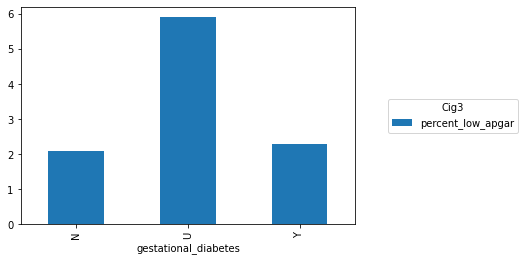

In [98]:
counts = (df[['gestational_diabetes', 'apgar_score']]
              .groupby(['gestational_diabetes', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [99]:
df['gestational_diabetes'].replace(to_replace='U', value=np.nan, inplace=True)

In [100]:
df['hypertension'].value_counts()

N    3657523
Y      83003
U       2383
Name: hypertension, dtype: int64

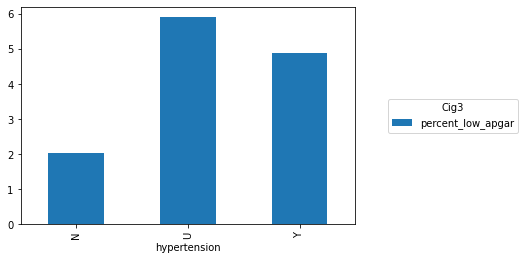

In [101]:
counts = (df[['hypertension', 'apgar_score']]
              .groupby(['hypertension', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [102]:
df['hypertension'].replace(to_replace='U', value=np.nan, inplace=True)

In [103]:
df['gestational_hypertension'].value_counts()

N    3448913
Y     291613
U       2383
Name: gestational_hypertension, dtype: int64

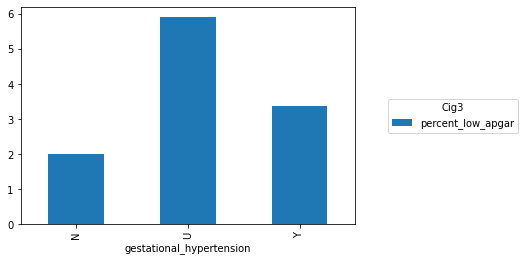

In [104]:
counts = (df[['gestational_hypertension', 'apgar_score']]
              .groupby(['gestational_hypertension', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [105]:
df['gestational_hypertension'].replace(to_replace='U', value=np.nan, inplace=True)

In [106]:
df['eclampsia'].value_counts()

N    3730014
Y      10512
U       2383
Name: eclampsia, dtype: int64

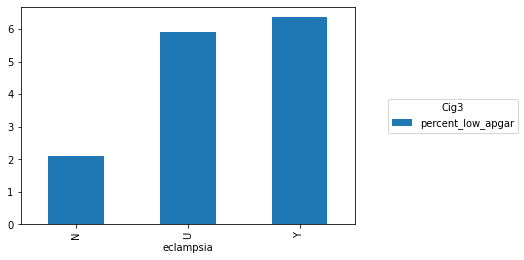

In [107]:
counts = (df[['eclampsia', 'apgar_score']]
              .groupby(['eclampsia', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [108]:
df['eclampsia'].replace(to_replace='U', value=np.nan, inplace=True)

In [109]:
df['previous_premature_birth'].value_counts()

N    3604510
Y     136016
U       2383
Name: previous_premature_birth, dtype: int64

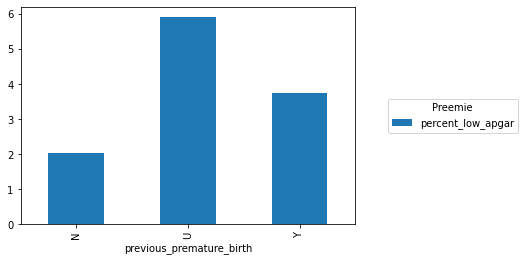

In [110]:
counts = (df[['previous_premature_birth', 'apgar_score']]
              .groupby(['previous_premature_birth', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [111]:
df['previous_premature_birth'].replace(to_replace='U', value=np.nan, inplace=True)

In [112]:
df['infertility_treatment'].value_counts()

N    3664515
Y      76011
U       2383
Name: infertility_treatment, dtype: int64

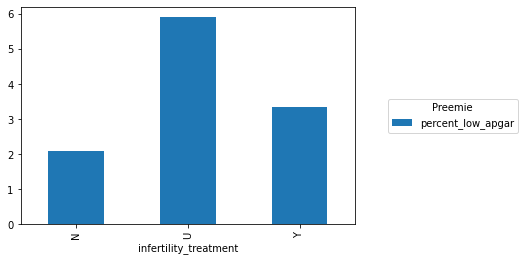

In [113]:
counts = (df[['infertility_treatment', 'apgar_score']]
              .groupby(['infertility_treatment', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [114]:
df['infertility_treatment'].replace(to_replace='U', value=np.nan, inplace=True)

In [115]:
df['fertility_drugs'].value_counts()

X    3664515
N      43026
Y      28984
U       6384
Name: fertility_drugs, dtype: int64

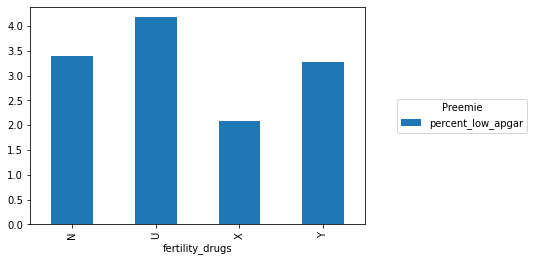

In [116]:
counts = (df[['fertility_drugs', 'apgar_score']]
              .groupby(['fertility_drugs', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [117]:
df['fertility_drugs'].replace(to_replace='U', value=np.nan, inplace=True)
df['fertility_drugs'].replace(to_replace='X', value='N', inplace=True)

In [118]:
df['assisted_reproduction'].value_counts()

X    3664515
Y      48871
N      23139
U       6384
Name: assisted_reproduction, dtype: int64

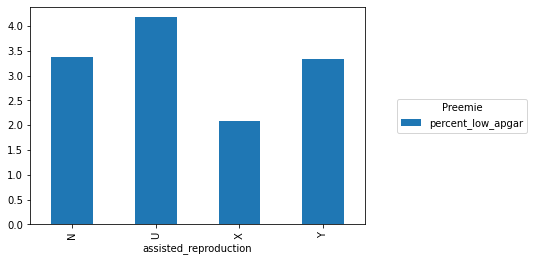

In [120]:
counts = (df[['assisted_reproduction', 'apgar_score']]
              .groupby(['assisted_reproduction', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [ ]:
df['assisted_reproduction'].replace(to_replace='U', value=np.nan, inplace=True)
df['assisted_reproduction'].replace(to_replace='X', value='N', inplace=True)

In [121]:
df['previous_cesareans'].value_counts()

0     3157888
1      396640
2      135893
3       37975
4        8635
99       3366
5        1909
6         430
7         126
8          32
9          11
10          3
12          1
Name: previous_cesareans, dtype: int64

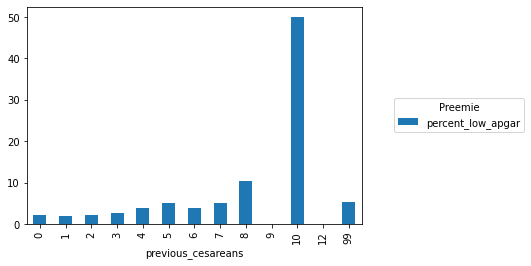

In [122]:
counts = (df[['previous_cesareans', 'apgar_score']]
              .groupby(['previous_cesareans', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [123]:
df['assisted_reproduction'].replace(to_replace=99, value=np.nan, inplace=True)

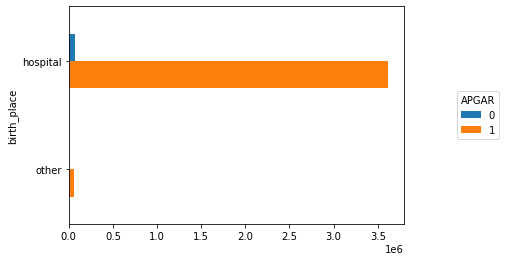

In [57]:
# Place of birth
counts = (df[['birth_place', 'apgar_score']]
              .groupby(['birth_place', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='APGAR'
)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3742909 entries, 0 to 3757581
Data columns (total 47 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   birth_place               object 
 1   mother_age                int64  
 2   mother_native             float64
 3   mother_race               object 
 4   mother_hispanic           float64
 5   marital_status            object 
 6   mother_education          object 
 7   father_age                float64
 8   living_children           float64
 9   deceased_children         float64
 10  terminations              float64
 11  months_prenatal_care      float64
 12  prenatal_visits           float64
 13  food_assistance           object 
 14  prepregnancy_daily_cig    int64  
 15  first_tri_daily_cig       int64  
 16  second_tri_daily_cig      int64  
 17  third_tri_daily_cig       int64  
 18  height                    int64  
 19  bmi                       float64
 20  delivery_weight         

In [59]:
df_cat = df.select_dtypes(include=['object'])

In [60]:
df_num = df.select_dtypes(include=['int64', 'float64'])

In [61]:
for c in df_cat.columns:
    print("---- %s ---" % c)
    print(df[c].value_counts())

---- birth_place ---
hospital    3686903
other         55944
Name: birth_place, dtype: int64
---- mother_race ---
white              2788731
black               632382
asian/pi            280217
native_american      41579
Name: mother_race, dtype: int64
---- marital_status ---
married      1968696
unmarried    1330007
Name: marital_status, dtype: int64
---- mother_education ---
hs_or_lower          2452423
college_or_higher    1237281
Name: mother_education, dtype: int64
---- food_assistance ---
N    2447990
Y    1252530
U      42389
Name: food_assistance, dtype: int64
---- diabetes ---
N    3704010
Y      36516
U       2383
Name: diabetes, dtype: int64
---- gestational_diabetes ---
N    3481937
Y     258589
U       2383
Name: gestational_diabetes, dtype: int64
---- hypertension ---
N    3657523
Y      83003
U       2383
Name: hypertension, dtype: int64
---- gestational_hypertension ---
N    3448913
Y     291613
U       2383
Name: gestational_hypertension, dtype: int64
---- eclampsia -

In [62]:
df_cat.columns

Index(['birth_place', 'mother_race', 'marital_status', 'mother_education',
       'food_assistance', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c',
       'steroids', 'antibiotics', 'chorioamnionitis', 'infant_sex',
       'down_syndrome'],
      dtype='object')

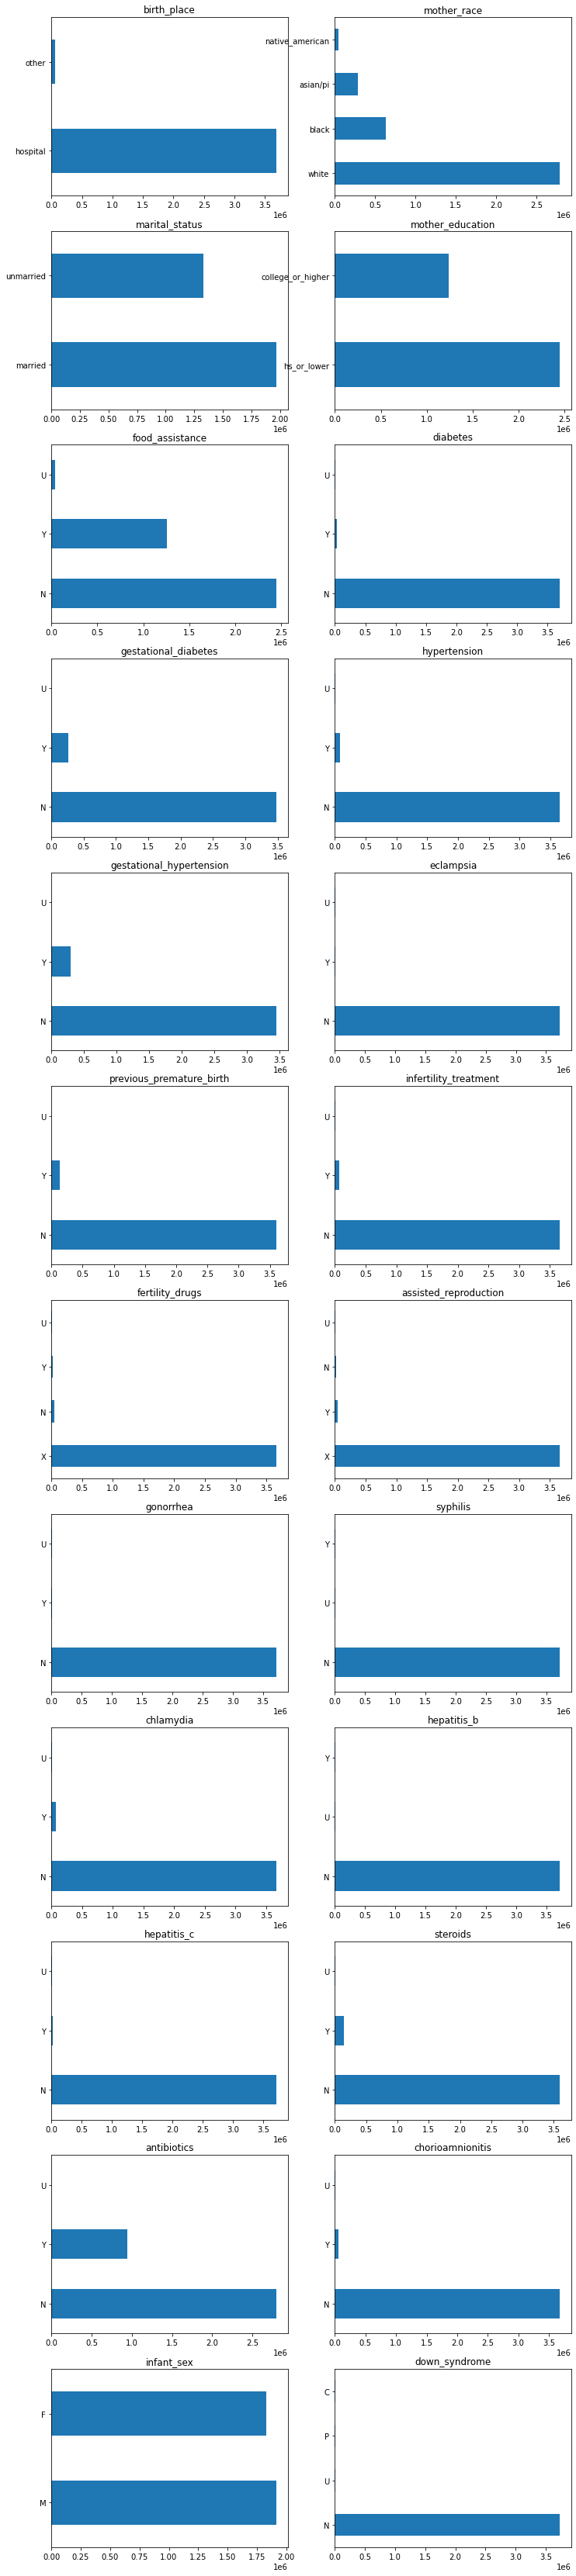

In [63]:
fig, axis = plt.subplots(nrows = int((len(df_cat.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_cat.columns, axis.ravel()):
    df_cat[i].value_counts().plot(kind='barh', ax=subplot, title = i)

<ipython-input-65-db2104ea8bab>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=axis, bins='auto')


array([[<AxesSubplot:title={'center':'mother_age'}>,
        <AxesSubplot:title={'center':'mother_native'}>,
        <AxesSubplot:title={'center':'mother_hispanic'}>,
        <AxesSubplot:title={'center':'father_age'}>,
        <AxesSubplot:title={'center':'living_children'}>],
       [<AxesSubplot:title={'center':'deceased_children'}>,
        <AxesSubplot:title={'center':'terminations'}>,
        <AxesSubplot:title={'center':'months_prenatal_care'}>,
        <AxesSubplot:title={'center':'prenatal_visits'}>,
        <AxesSubplot:title={'center':'prepregnancy_daily_cig'}>],
       [<AxesSubplot:title={'center':'first_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'second_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'third_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'delivery_weight'}>,
        <AxesSubplot:title={'center':'weight_gain'}>,
        <AxesSubplot:tit

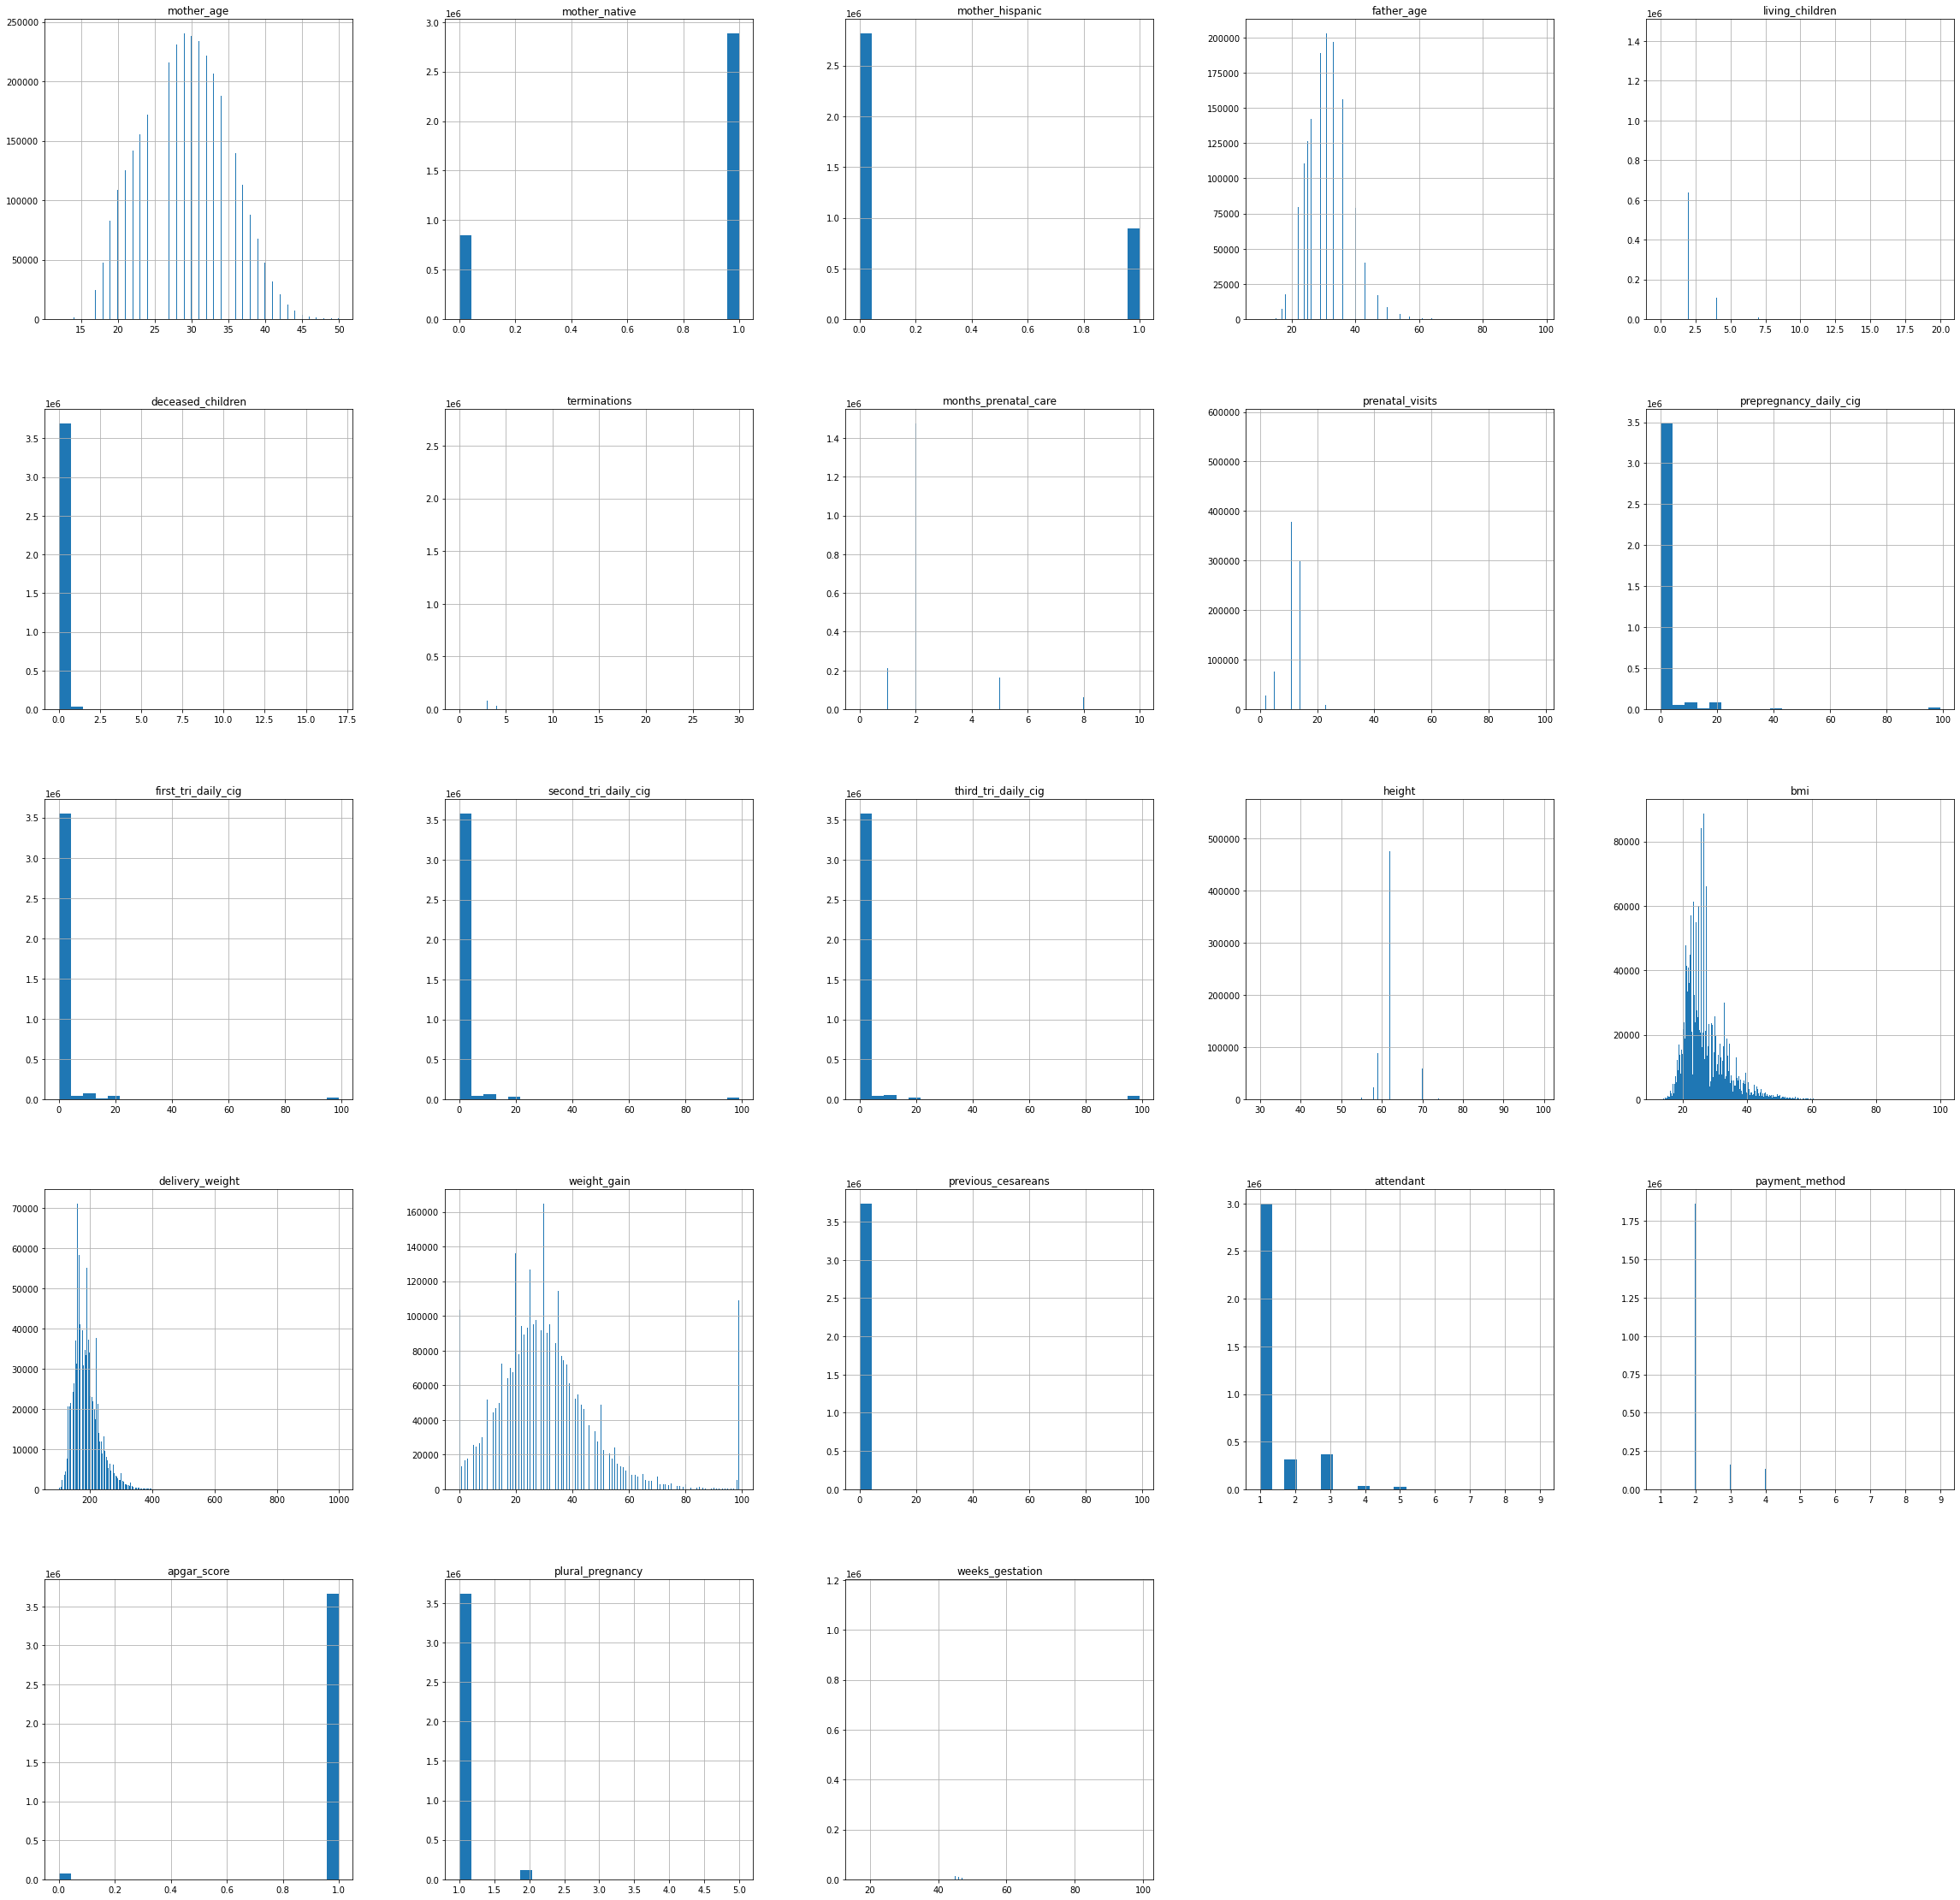

In [65]:
fig, axis = plt.subplots(figsize=(40, 40))
df.hist(ax=axis, bins='auto')